In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from datetime import date
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pickle
from prophet.serialize import model_to_json, model_from_json
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_cross_validation_metric, plot_components_plotly, add_changepoints_to_plot, plot_yearly
from prophet.serialize import model_to_json, model_from_json

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
#!unzip household_power_consumption.zip

In [3]:
pd.set_option("display.float_format", "{:.2f}".format)

In [4]:
# The ds (datestamp) column should be of a format expected by Pandas,
# ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

In [5]:
df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True, low_memory=False)
del df['Sub_metering_1']
del df['Sub_metering_2']
del df['Sub_metering_3']
del df['Global_reactive_power']
del df['Voltage']
del df['Global_intensity']

df

,ds,Global_active_power
0,2006-12-16 17:24:00,4.22
1,2006-12-16 17:25:00,5.36
2,2006-12-16 17:26:00,5.37
3,2006-12-16 17:27:00,5.39
4,2006-12-16 17:28:00,3.67
...,...,...
2075254,2010-11-26 20:58:00,0.95
2075255,2010-11-26 20:59:00,0.94
2075256,2010-11-26 21:00:00,0.94
2075257,2010-11-26 21:01:00,0.93


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 2 columns):
 #   Column               Dtype         
---  ------               -----         
 0   ds                   datetime64[ns]
 1   Global_active_power  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.7 MB


In [7]:
df

,ds,Global_active_power
0,2006-12-16 17:24:00,4.22
1,2006-12-16 17:25:00,5.36
2,2006-12-16 17:26:00,5.37
3,2006-12-16 17:27:00,5.39
4,2006-12-16 17:28:00,3.67
...,...,...
2075254,2010-11-26 20:58:00,0.95
2075255,2010-11-26 20:59:00,0.94
2075256,2010-11-26 21:00:00,0.94
2075257,2010-11-26 21:01:00,0.93


In [8]:
df.head(15)

,ds,Global_active_power
0,2006-12-16 17:24:00,4.22
1,2006-12-16 17:25:00,5.36
2,2006-12-16 17:26:00,5.37
3,2006-12-16 17:27:00,5.39
4,2006-12-16 17:28:00,3.67
5,2006-12-16 17:29:00,3.52
6,2006-12-16 17:30:00,3.70
7,2006-12-16 17:31:00,3.70
8,2006-12-16 17:32:00,3.67
9,2006-12-16 17:33:00,3.66


In [9]:
df.isna().sum()

ds                         0
Global_active_power    25979
dtype: int64

In [10]:
df.describe(include='all').T

C:\Users\pauli\AppData\Local\Temp\ipykernel_14580\377021028.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ds,2075259,2075259,2006-12-16 17:24:00,1,2006-12-16 17:24:00,2010-11-26 21:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Global_active_power,2049280.00,NaN,NaT,NaN,NaT,NaT,1.09,1.06,0.08,0.31,0.60,1.53,11.12


In [11]:
df = df.fillna(df.shift(60*24*7))

In [12]:
df.isna().sum()

ds                     0
Global_active_power    3
dtype: int64

In [13]:
df = df.fillna(df.shift(60*24*7))

In [14]:
df.isna().sum()

ds                     0
Global_active_power    2
dtype: int64

In [15]:
df = df.fillna(df.shift(60*24))

In [16]:
df.isna().sum()

ds                     0
Global_active_power    0
dtype: int64

In [17]:
df.describe(include='all').T

C:\Users\pauli\AppData\Local\Temp\ipykernel_14580\377021028.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ds,2075259,2075259,2006-12-16 17:24:00,1,2006-12-16 17:24:00,2010-11-26 21:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Global_active_power,2075259.00,NaN,NaT,NaN,NaT,NaT,1.09,1.06,0.08,0.31,0.60,1.53,11.12


In [19]:
df["Global_active_power"] = df["Global_active_power"].apply(lambda x: x/60)

In [20]:
df_H = df.resample('H', on="ds").mean()
df_H= df_H.reset_index(drop=False)
df_H.head()

,ds,Global_active_power
0,2006-12-16 17:00:00,0.07
1,2006-12-16 18:00:00,0.06
2,2006-12-16 19:00:00,0.06
3,2006-12-16 20:00:00,0.05
4,2006-12-16 21:00:00,0.05


## Other charts

In [23]:
# Create new columns for year, quarter, month, and day
df['year'] = df['ds'].apply(lambda x: x.year)
df['quarter'] = df['ds'].apply(lambda x: x.quarter)
df['month'] = df['ds'].apply(lambda x: x.month)
df['day'] = df['ds'].apply(lambda x: x.day)
df = df.loc[:,['ds','Global_active_power', 'year','quarter','month','day']]
df.tail(5)


,ds,Global_active_power,year,quarter,month,day
2075254,2010-11-26 20:58:00,0.02,2010,4,11,26
2075255,2010-11-26 20:59:00,0.02,2010,4,11,26
2075256,2010-11-26 21:00:00,0.02,2010,4,11,26
2075257,2010-11-26 21:01:00,0.02,2010,4,11,26
2075258,2010-11-26 21:02:00,0.02,2010,4,11,26


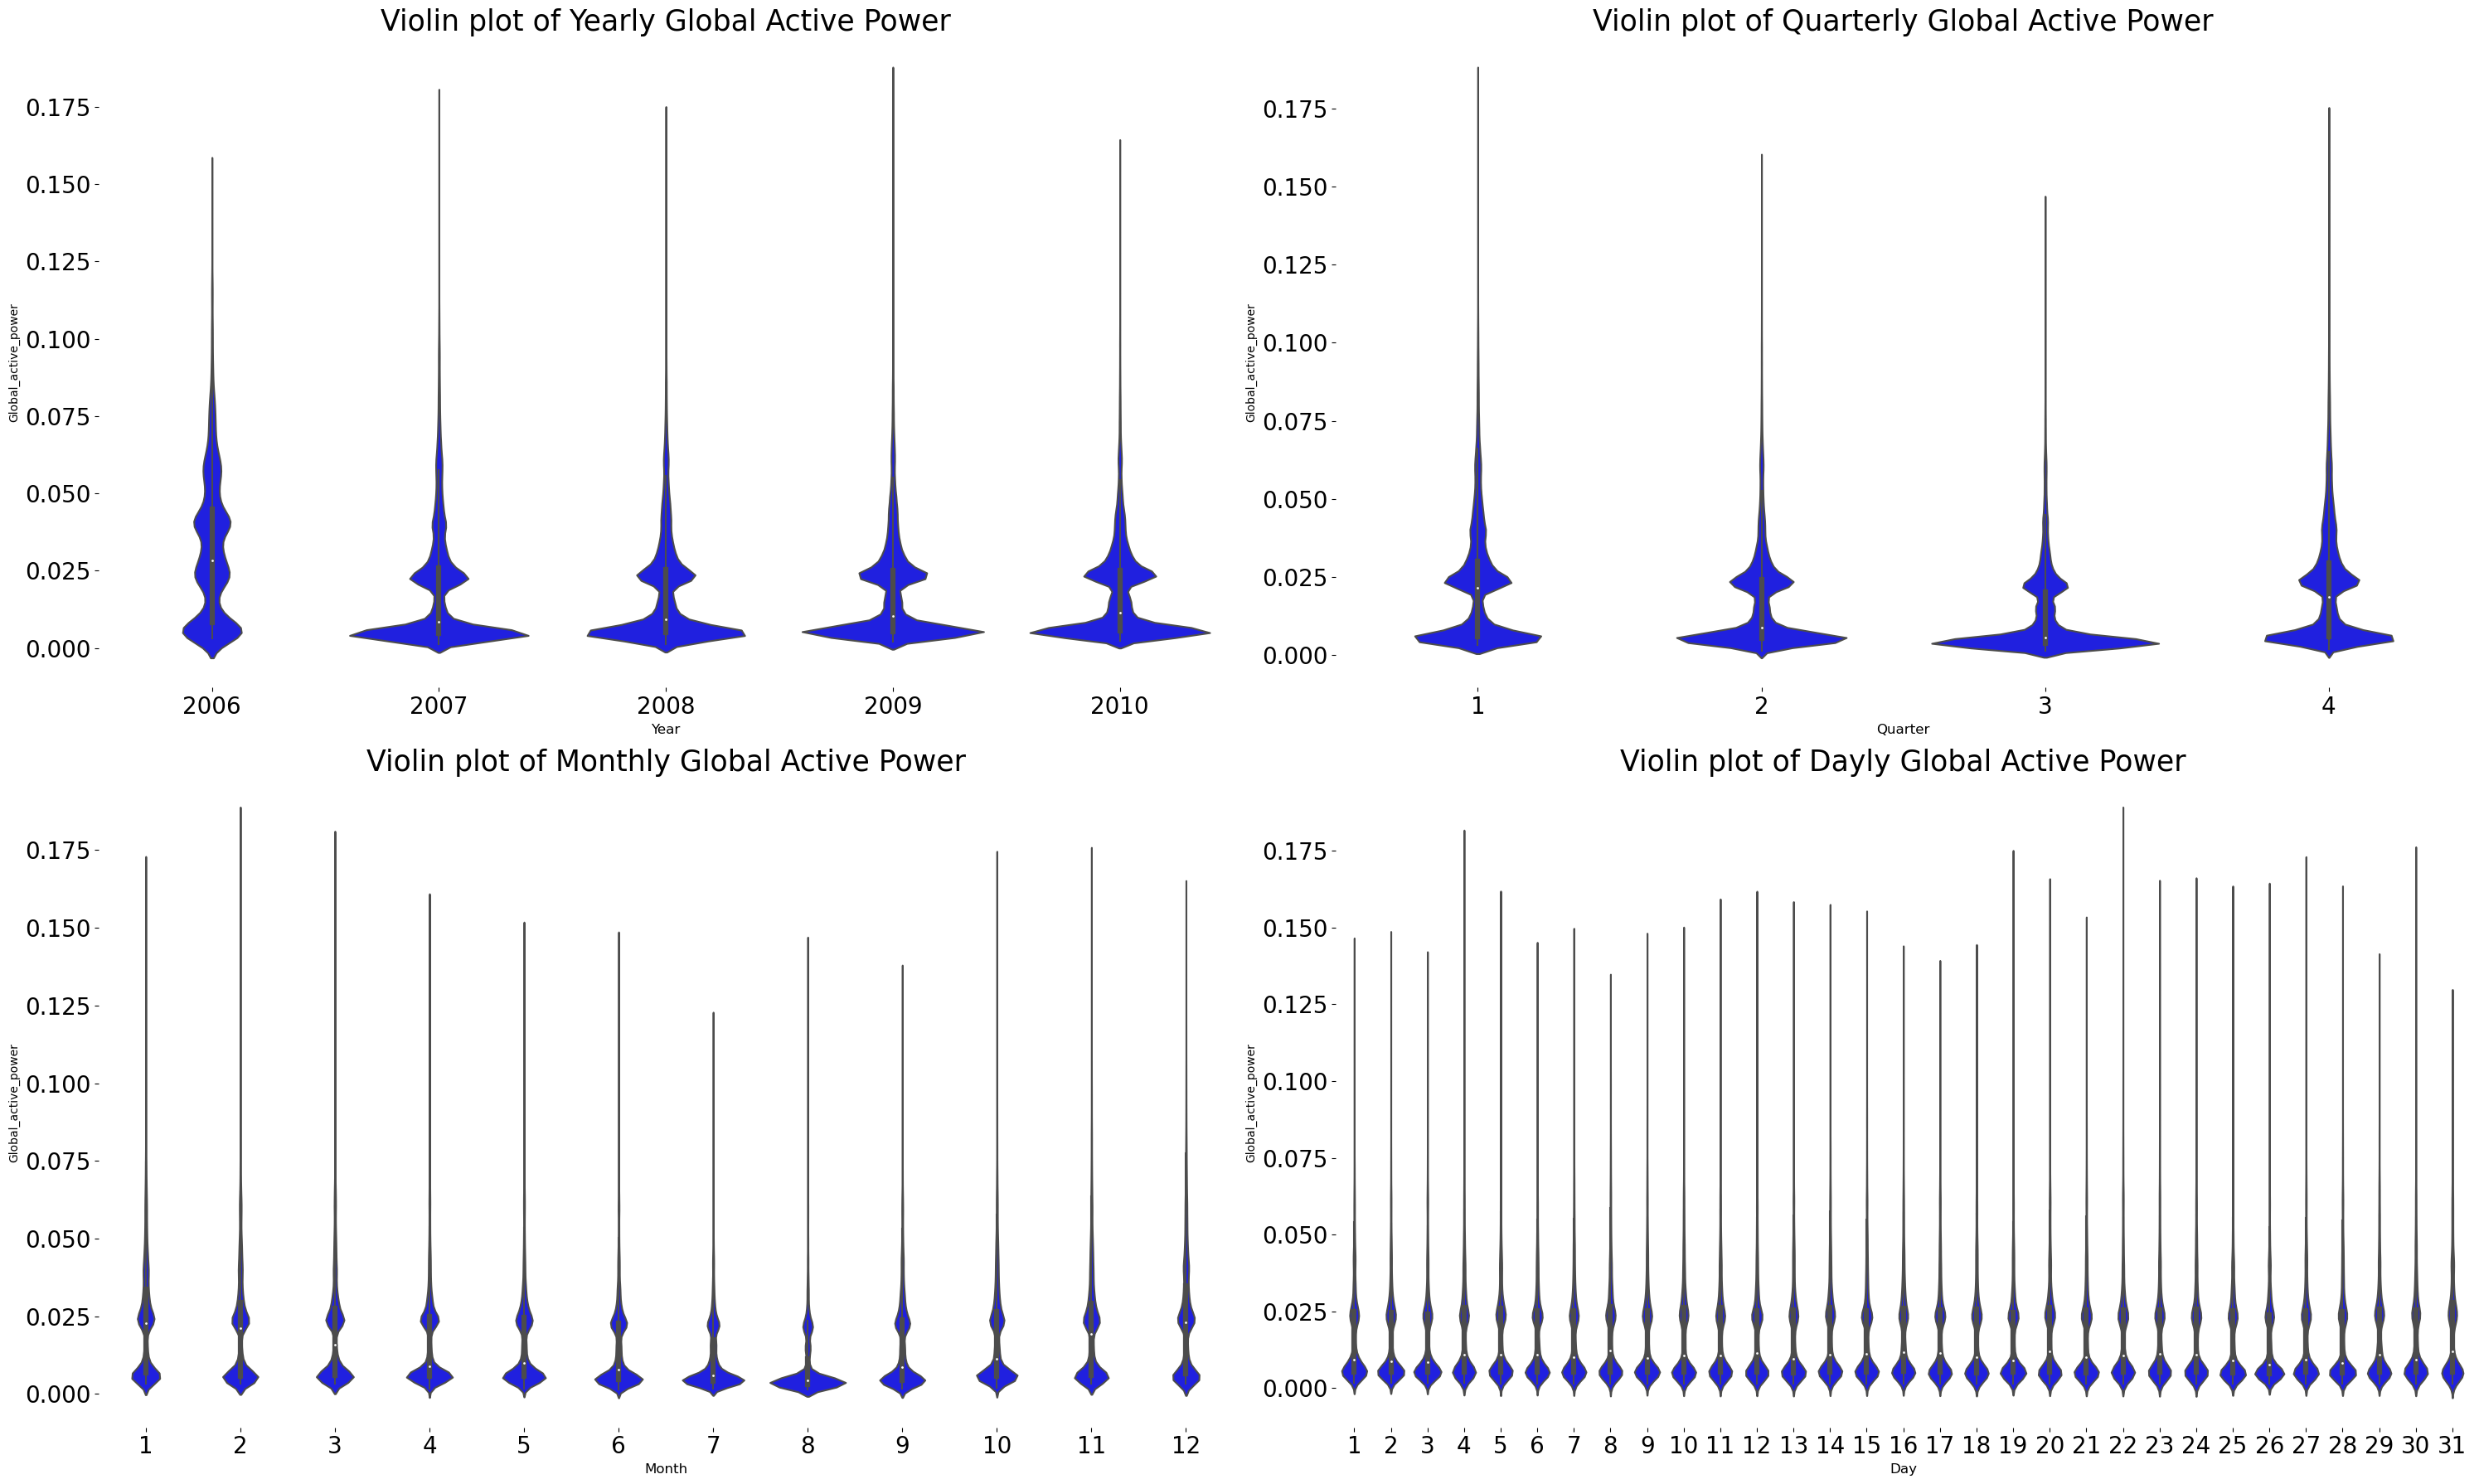

In [24]:
# Create a figure with 4 subplots
plt.figure(figsize=(30,18))

# Plot the first subplot showing the violinplot of yearly global active power
plt.subplot(2,2,1)
# Adjust the subplot's width
plt.subplots_adjust(wspace=0.2)
# Create the violinplot using Seaborn's violinplot function
sns.violinplot(x="year", y="Global_active_power", data=df, color='blue')
# Label the x-axis
plt.xlabel('Year', fontsize=12)
# Add a title to the plot
plt.title('Violin plot of Yearly Global Active Power', fontsize=25)
# Remove the top and right spines of the plot
sns.despine(left=True, bottom=True)
# Add a tight layout to the plot
plt.tight_layout() 
plt.tick_params(axis='x', labelcolor='#000000', labelsize = 20)
plt.tick_params(axis='y', labelcolor='#000000', labelsize = 20)

# Plot the second subplot showing the violinplot of quarterly global active power
plt.subplot(2,2,2)
sns.violinplot(x="quarter", y="Global_active_power", data=df, color='blue')
plt.xlabel('Quarter', fontsize=12)
plt.title('Violin plot of Quarterly Global Active Power', fontsize=25)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.tick_params(axis='x', labelcolor='#000000', labelsize = 20)
plt.tick_params(axis='y', labelcolor='#000000', labelsize = 20)

# Plot the second subplot showing the violinplot of monthly global active power
plt.subplot(2,2,3)
sns.violinplot(x="month", y="Global_active_power", data=df, color='blue')
plt.xlabel('Month', fontsize=12)
plt.title('Violin plot of Monthly Global Active Power', fontsize=25)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.tick_params(axis='x', labelcolor='#000000', labelsize = 20)
plt.tick_params(axis='y', labelcolor='#000000', labelsize = 20)

# Plot the second subplot showing the violinplot of dayly global active power
plt.subplot(2,2,4)
sns.violinplot(x="day", y="Global_active_power", data=df, color='blue')
plt.xlabel('Day', fontsize=12)
plt.title('Violin plot of Dayly Global Active Power', fontsize=25)
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.tick_params(axis='x', labelcolor='#000000', labelsize = 20)
plt.tick_params(axis='y', labelcolor='#000000', labelsize = 20)